# Feature Selection - Classification
_**Code Pipeline for using multiple feature selection methods for classification purpose**_

---

---


## Contents

1. [Purpose](#Purpose)
2. [Steps](#Steps)
3. [Data](#Data)
4. [Instructions](#Instructions)



## Purpose:

_This notebook is a one stop shop for ML based feature selection for classification purpose. Once the master data is prepared, we can use this notebook to try out 8 feature selection techniques and combine their results_



## Steps:

### Step 1: Load Package and Custom Functions

1. Install/Import necesarry packages
2. Load custom functions
3. Input user defined metrics


### Step 2: Data Preparation:

1. Import dataset
2. Profiling and EDA
3. Drop unwanted fields and convert column types
4. Null Treatment
5. Treating categorical features (one hot encoding, WOE encoding)
6. Train/Test/OOT Split


### Step 3: Feature Selection

_Methods_:

1. Correlation: Pearson, Point Bi-Serial, Cramer's V [reading materials](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)
2. Weight of Evidence and Information Value [reading materials](https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/)
3. Beta Coefficients [reading materials](https://www.statisticshowto.com/standardized-beta-coefficient/)
4. Lasso Regression [reading materials](https://machinelearningmastery.com/lasso-regression-with-python/)
5. Recursive Feature Selection [reading materials](https://scikit-learn.org/stable/modules/feature_selection.html#rfe)
6. Sequential Feature Selector [reading materials](https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection)
7. BorutaPy [reading materials](https://github.com/scikit-learn-contrib/boruta_py)
8. BorutaShap [reading materials](https://medium.com/analytics-vidhya/is-this-the-best-feature-selection-algorithm-borutashap-8bc238aa1677)

_Features selected by majority of the methods will be picked for modelling.Users can select all methods or a subset of them_



## Data

_We are using the [(default of credit card clients)](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) data. It has 30,000 records on customer default payments in Taiwan and has 23 features_:

1. Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
2. Gender (1 = male; 2 = female).
3. Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
4. Marital status (1 = married; 2 = single; 3 = others).
5. Age (year).
6. History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
7. Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
8. Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.


## Instructions

Users need to update the manual inputs section and the rest of the notebook should run smoothly






## Step 1: Load Packages and Custom Functions

In [144]:
# Import Libraries


import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random
import time
import pandas_profiling as pp
import glob
import re

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import pointbiserialr,chi2_contingency
import category_encoders as ce

import sklearn
from boruta import BorutaPy
from sklearn.linear_model import LogisticRegression, LassoCV
import statsmodels.api as sm
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from BorutaShap import BorutaShap
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV



from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.ensemble import IsolationForest
import eif as iso
import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator
from sklearn.covariance import EllipticEnvelope


from scipy.stats import norm
from sklearn.metrics import (roc_auc_score,classification_report,confusion_matrix,
                             precision_recall_curve, auc, roc_curve, recall_score, f1_score, 
                             precision_recall_fscore_support, roc_auc_score)
 



import seaborn as sns
import matplotlib.pyplot as plt




## Step 2: Data Preparation

In [145]:
# Data Prep

Input_Data = "Data//Default_of_credit_card_clients.csv"

fields_to_drop = ['ID']

string_columns = ['SEX', 'EDUCATION', 'MARRIAGE',  'PAY_0',
                   'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

numeric_columns = ['default payment next month']

null_handling_required = True


# Train and Test

WOE_encoding = True

target = 'default payment next month'

test = 0.3

shuffle_flag = True

stratify_flag = True



In [146]:
# Data Prep Functions

def data_prep(data, fields_to_drop, string_columns, numeric_columns,null_handling_required):
    try:
        data_v2 = data.copy()
        #Drop unwanted fields
        if len(fields_to_drop)>0:
            data_v2 = data_v2.drop(fields_to_drop, axis = 1)
            print('Dropped {} Fields'.format(len(fields_to_drop)))
        else:
            print('No Fields to Drop')
            
        # Convert String Columns
        
        if len(string_columns)>0:
            data_v2[string_columns] = data_v2[string_columns].astype(str)
            print('{} Fields converted to string'.format(len(string_columns)))
        else:
            print('No Fields to Convert to String')
            
            
        # Convert NUmeric Columns
        
        if len(numeric_columns)>0:
            data_v2[numeric_columns] = data_v2[string_columns].astype(float)
            print('{} Fields converted to string'.format(len(numeric_columns)))
        else:
            print('No Fields to Convert to Numeric')
            
        #Null Treatment
        
        if null_handling_required == True:
            print('Number of records before dropping nulls:',len(data_v2))
            data_v2 = data_v2.dropna()
            print('Number of records after dropping nulls:',len(data_v2))
        else:
            print('No Null Treatment')
            
    except:
        print('Error: Reload data and check manual inputs')
        
    return data_v2




# WOE

def WOE(train_features, test_features,train_target, test_target):
    WOE_columns = train_features.select_dtypes(exclude = [np.number]).columns
    
    woe_encoder = ce.WOEEncoder(cols = WOE_columns)
    
    WOE_encoded_train = woe_encoder.fit_transform(train_features[WOE_columns],train_target).add_suffix('_woe')
    train_features = pd.concat([train_features,WOE_encoded_train],axis=1)
    
    WOE_encoded_test = woe_encoder.fit_transform(test_features[WOE_columns],test_target).add_suffix('_woe')
    test_features = pd.concat([test_features,WOE_encoded_test],axis=1)
    
    train_features_v2 = train_features.drop(WOE_columns,axis =1)
    test_features_v2 = test_features.drop(WOE_columns,axis =1)
    
    return train_features_v2, test_features_v2
    
            
            
# Train Test Prep Function


def train_test(data, target, test, shuffle_flag, stratify_flag,WOE_encoding):
     
    # Define X and Y
    features = data.drop([target], axis=1)
    Target = data[target]
    print('Target Distribution:')
    print(data[target].value_counts())
    
    
    # Treating Categorical Features and Train/Test Split
    
    
    if WOE_encoding == True:
        # Train and Test Split
        if stratify_flag == True:
            train_features, test_features, train_target, test_target = train_test_split(features, Target, test_size = test, shuffle = shuffle_flag, stratify = Target)
        else:
            train_features, test_features, train_target, test_target = train_test_split(features, Target, test_size = test, shuffle = shuffle_flag)
            
        train_features, test_features = WOE(train_features, test_features,train_target, test_target)
        
    else:
        features = pd.get_dummies(features, drop_first = True)
        # Train and Test Split
        
        if stratify_flag == True:
            train_features, test_features, train_target, test_target = train_test_split(features, Target, test_size = test, shuffle = shuffle_flag, stratify = Target)
        else:
            train_features, test_features, train_target, test_target = train_test_split(features, Target, test_size = test, shuffle = shuffle_flag)
     
    # Summary
    
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_target.shape)
    
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_target.shape)
    
    train_features = train_features.astype(float)
    train_target = train_target.astype(float)
    test_features = test_features.astype(float)
    test_target = test_target.astype(float)
    
    return train_features, test_features, train_target, test_target, features, Target
    
    

In [147]:
# Read Input Dataset
df = pd.read_csv(Input_Data)
pd.set_option("display.max_columns", 500)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [148]:
# Basic info on input Data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [149]:
# Data Prep

df_v2 = data_prep(df, fields_to_drop, string_columns, numeric_columns,null_handling_required)
df_v2.info()

Dropped 1 Fields
9 Fields converted to string
Error: Reload data and check manual inputs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   LIMIT_BAL                   30000 non-null  int64 
 1   SEX                         30000 non-null  object
 2   EDUCATION                   30000 non-null  object
 3   MARRIAGE                    30000 non-null  object
 4   AGE                         30000 non-null  int64 
 5   PAY_0                       30000 non-null  object
 6   PAY_2                       30000 non-null  object
 7   PAY_3                       30000 non-null  object
 8   PAY_4                       30000 non-null  object
 9   PAY_5                       30000 non-null  object
 10  PAY_6                       30000 non-null  object
 11  BILL_AMT1                   30000 non-null  int64 
 12  BILL_AMT2    

In [ ]:
# Generate Data Profile - Updated

df_profile_v2 = pp.ProfileReport(df_v2)
df_profile_v2.to_file('preped_base_data_profile.html')

In [151]:
# Create Train and Test Data

train_features, test_features, train_target, test_target, features, Target = train_test(df_v2, target, test, shuffle_flag, stratify_flag,WOE_encoding)
train_features_v2 = train_features.fillna(0)
train_features.info()

Target Distribution:
0    23364
1     6636
Name: default payment next month, dtype: int64
Training Features Shape: (21000, 23)
Training Labels Shape: (21000,)
Testing Features Shape: (9000, 23)
Testing Labels Shape: (9000,)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 2636 to 1671
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LIMIT_BAL      21000 non-null  float64
 1   AGE            21000 non-null  float64
 2   BILL_AMT1      21000 non-null  float64
 3   BILL_AMT2      21000 non-null  float64
 4   BILL_AMT3      21000 non-null  float64
 5   BILL_AMT4      21000 non-null  float64
 6   BILL_AMT5      21000 non-null  float64
 7   BILL_AMT6      21000 non-null  float64
 8   PAY_AMT1       21000 non-null  float64
 9   PAY_AMT2       21000 non-null  float64
 10  PAY_AMT3       21000 non-null  float64
 11  PAY_AMT4       21000 non-null  float64
 12  PAY_AMT5       21000 non-null  float64
 13  

In [152]:
# Get Feature Names
train_features.columns

Index(['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX_woe', 'EDUCATION_woe',
       'MARRIAGE_woe', 'PAY_0_woe', 'PAY_2_woe', 'PAY_3_woe', 'PAY_4_woe',
       'PAY_5_woe', 'PAY_6_woe'],
      dtype='object')

# Step 3: Feature Selection

In [159]:
# Manual Inputs 



# Correlation

pearson_list = []
point_bi_serial_list = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 
                        'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                        'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 
                        'PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 
                        'PAY_AMT5', 'PAY_AMT6']

cramer_list = ['SEX_woe', 'EDUCATION_woe',
               'MARRIAGE_woe', 'PAY_0_woe', 
               'PAY_2_woe', 'PAY_3_woe', 'PAY_4_woe',
               'PAY_5_woe', 'PAY_6_woe']

pearson_threshold = .5
point_bi_serial_threshold = .5
cramer_threshold = .1


# Information value

show_woe = True
iv_bins = 10
iv_threshold = .1

# Beta Coefficients

beta_threshold = 10


# Lasso

lasso_param = .01


# RFECV

rfe_estimator = "XGBoost"
rfe_step = 2
rfe_cv = 5
rfe_scoring = 'f1'


# Sequential Feature Selector

sfs_feature = 10
sfs_direction = 'backward'
sfs_cv = 2
sfs_scoring = 'r2'

# BorutaPy:
borutapy_estimator = "XGBoost"
borutapy_trials = 10
borutapy_green_blue = "both"

# BorutaShap:
borutashap_estimator = "XGBoost"
borutashap_trials = 10
borutashap_green_blue = 'both'




In [154]:
#1.Select the top n features based on absolute correlation with train_target variable

################################ Functions #############################################################

# Function to calculate Cramer's V
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, 
                                 rownames=None, colnames=None))
  stat = chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab) 
  mini = min(crosstab.shape)-1 
  return (stat/(obs*mini))



# Overall Correlation Function
def corr_feature_selection(data,target,pearson_list,
                           point_bi_serial_list,cramer_list,
                           pearson_threshold,
                           point_bi_serial_threshold,
                           cramer_threshold):
    
    #Inputs
    # data - Input feature data
    # target - Target Variable
    # pearson_list - list of continuous features (if target is continuous)
    # point_bi_serial_list - list of continuous features (if target is categorical)/
    #                        list of categorical features (if target is continuous)   
    # cramer_list - list of categorical features (if target is categorical)
    # pearson_threshold - select features if pearson corrrelation is above this
    # point_bi_serial_threshold - select features if biserial corrrelation is above this
    # cramer_threshold - select features if cramer's v is above this  
    
    corr_data = pd.DataFrame()

    # Calculate point bi-serial
    for i in point_bi_serial_list:
        # Manual Change in Parameters - Point Bi-Serial
        # Link to function parameters - https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.pointbiserialr.html
        pbc = pointbiserialr(target, data[i])   
        corr_temp_data = [[i,pbc.correlation,"point_bi_serial"]]
        corr_temp_df = pd.DataFrame(corr_temp_data, 
                                    columns = ['Feature', 
                                               'Correlation',
                                               'Correlation_Type'])
        corr_data = corr_data.append(corr_temp_df)

    # Calculate cramer's v
    for i in cramer_list:
        cramer = cramers_V(target, data[i])
        corr_temp_data = [[i,cramer,"cramer_v"]]
        corr_temp_df = pd.DataFrame(corr_temp_data,
                                    columns = ['Feature',
                                               'Correlation',
                                               'Correlation_Type'])
        corr_data = corr_data.append(corr_temp_df)


    # Calculate pearson correlation
    for i in pearson_list:
        # Manual Change in Parameters - Perason
        # Link to function parameters - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html
        pearson = target.corr(data[i])
        corr_temp_data = [[i,pearson,"pearson"]]
        corr_temp_df = pd.DataFrame(corr_temp_data,
                                    columns = ['Feature',
                                               'Correlation',
                                               'Correlation_Type'])
        corr_data = corr_data.append(corr_temp_df)


    # Filter NA and sort based on absolute correlation
    corr_data = corr_data.iloc[corr_data.Correlation.abs().argsort()] 
    corr_data = corr_data[corr_data['Correlation'].notna()]
    corr_data = corr_data.loc[corr_data['Correlation'] != 1]
    
    # Add thresholds
    
    # initialize list of lists
    data = [['pearson', pearson_threshold],
            ['point_bi_serial', point_bi_serial_threshold],
            ['cramer_v', cramer_threshold]]

    threshold_df = pd.DataFrame(data,
                                columns=['Correlation_Type',
                                         'Threshold'])
    corr_data = pd.merge(corr_data,threshold_df,
                         on=['Correlation_Type'],how = 'left')
    



    # Select Features with greater than user dfined absolute correlation
    corr_data2 = corr_data.loc[corr_data['Correlation'].abs() > corr_data['Threshold']]
    corr_top_features = corr_data2['Feature'].tolist()
    print(corr_top_features)
    corr_top_features_df = pd.DataFrame(corr_top_features,columns = ['Feature'])
    corr_top_features_df['Method'] = 'Correlation'
    return corr_data,corr_top_features_df

################################ Calculate Correlation #############################################################


corr_data,corr_top_features_df = corr_feature_selection(train_features_v2,train_target,
                                   pearson_list,point_bi_serial_list,
                                   cramer_list,pearson_threshold,
                                   point_bi_serial_threshold,cramer_threshold)
    
    
corr_data.tail(30)

['PAY_2_woe', 'PAY_0_woe']


,Feature,Correlation,Correlation_Type,Threshold
0,MARRIAGE_woe,0.001191,cramer_v,0.1
1,SEX_woe,0.001624,cramer_v,0.1
2,BILL_AMT6,-0.004103,point_bi_serial,0.5
3,EDUCATION_woe,0.005169,cramer_v,0.1
4,BILL_AMT5,-0.005521,point_bi_serial,0.5
5,BILL_AMT4,-0.007748,point_bi_serial,0.5
6,BILL_AMT3,-0.012937,point_bi_serial,0.5
7,BILL_AMT2,-0.013501,point_bi_serial,0.5
8,AGE,0.016946,point_bi_serial,0.5
9,BILL_AMT1,-0.017426,point_bi_serial,0.5


In [156]:
#2. Select top features based on information value


################################ Functions #############################################################

def iv_woe(data, target, iv_bins,iv_threshold, show_woe):
    
    #Inputs
    # data - Input Data including target variable
    # target - Target Variable name
    # iv_bins - Number of iv_bins
    # show_woe - show all the iv_bins and features
    # iv_threshold - select features with IV greater than this
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], iv_bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})

        
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % 
        # of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + 
              str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars],
                            "IV" : [d['IV'].sum()]},
                           columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    
    # Aggregate IV at feature level
    woeDF_v2 = pd.DataFrame(woeDF.groupby('Variable')['IV'].agg('sum'),
                            columns= ['IV']).reset_index()
    woeDF_v3 = woeDF_v2.sort_values(['IV'], ascending = False)
    IV_df = woeDF_v2[woeDF_v2['IV']> iv_threshold]
    woe_top_features = IV_df['Variable'].tolist()
    print(woe_top_features)
    woe_top_features_df = pd.DataFrame(woe_top_features,columns = ['Feature'])
    woe_top_features_df['Method'] = 'Information_value'
    return newDF, woeDF,IV_df, woe_top_features_df


################################ Calculate IV #############################################################


train_features_v3_temp = pd.concat([train_target, train_features_v2],
                                   axis =1)

newDF, woeDF,IV_df, woe_top_features_df = iv_woe(train_features_v3_temp, 
                                              target,iv_bins,iv_threshold, 
                                              show_woe)
woeDF.head(n=50)

Information value of LIMIT_BAL is 0.168111
    Variable                 Cutoff     N  Events  % of Events  Non-Events  \
0  LIMIT_BAL    (9999.999, 30000.0]  2846  1016.0     0.218730      1830.0   
1  LIMIT_BAL     (30000.0, 50000.0]  2512   669.0     0.144026      1843.0   
2  LIMIT_BAL     (50000.0, 70000.0]  1079   307.0     0.066093       772.0   
3  LIMIT_BAL    (70000.0, 100000.0]  2333   557.0     0.119914      1776.0   
4  LIMIT_BAL   (100000.0, 140000.0]  1925   450.0     0.096878      1475.0   
5  LIMIT_BAL   (140000.0, 180000.0]  2281   412.0     0.088698      1869.0   
6  LIMIT_BAL   (180000.0, 210000.0]  1764   301.0     0.064801      1463.0   
7  LIMIT_BAL   (210000.0, 270000.0]  2090   347.0     0.074704      1743.0   
8  LIMIT_BAL   (270000.0, 360000.0]  2462   382.0     0.082239      2080.0   
9  LIMIT_BAL  (360000.0, 1000000.0]  1708   204.0     0.043918      1504.0   

   % of Non-Events       WoE        IV  
0         0.111892  0.670300  0.071613  
1         0.1126

   Variable              Cutoff     N  Events  % of Events  Non-Events  \
0  PAY_AMT5     (-0.001, 500.0]  6423  1776.0     0.382347      4647.0   
1  PAY_AMT5     (500.0, 1000.0]  2520   605.0     0.130248      1915.0   
2  PAY_AMT5    (1000.0, 1500.0]  1624   383.0     0.082454      1241.0   
3  PAY_AMT5    (1500.0, 2100.0]  2042   465.0     0.100108      1577.0   
4  PAY_AMT5    (2100.0, 3200.0]  2119   395.0     0.085038      1724.0   
5  PAY_AMT5    (3200.0, 5000.0]  2197   403.0     0.086760      1794.0   
6  PAY_AMT5    (5000.0, 9508.5]  1975   354.0     0.076211      1621.0   
7  PAY_AMT5  (9508.5, 426529.0]  2100   264.0     0.056835      1836.0   

   % of Non-Events       WoE        IV  
0         0.284133  0.296884  0.029158  
1         0.117090  0.106498  0.001401  
2         0.075879  0.083104  0.000546  
3         0.096423  0.037500  0.000138  
4         0.105411 -0.214774  0.004376  
5         0.109691 -0.234524  0.005378  
6         0.099113 -0.262759  0.006018  
7    

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,LIMIT_BAL,"(9999.999, 30000.0]",2846,1016.0,0.218730,1830.0,0.111892,0.670300,0.071613
1,LIMIT_BAL,"(30000.0, 50000.0]",2512,669.0,0.144026,1843.0,0.112687,0.245376,0.007690
2,LIMIT_BAL,"(50000.0, 70000.0]",1079,307.0,0.066093,772.0,0.047203,0.336605,0.006358
3,LIMIT_BAL,"(70000.0, 100000.0]",2333,557.0,0.119914,1776.0,0.108591,0.099189,0.001123
4,LIMIT_BAL,"(100000.0, 140000.0]",1925,450.0,0.096878,1475.0,0.090186,0.071577,0.000479
5,LIMIT_BAL,"(140000.0, 180000.0]",2281,412.0,0.088698,1869.0,0.114277,-0.253393,0.006482
6,LIMIT_BAL,"(180000.0, 210000.0]",1764,301.0,0.064801,1463.0,0.089453,-0.322392,0.007948
7,LIMIT_BAL,"(210000.0, 270000.0]",2090,347.0,0.074704,1743.0,0.106573,-0.355296,0.011323
8,LIMIT_BAL,"(270000.0, 360000.0]",2462,382.0,0.082239,2080.0,0.127178,-0.435960,0.019592
9,LIMIT_BAL,"(360000.0, 1000000.0]",1708,204.0,0.043918,1504.0,0.091960,-0.739021,0.035504


In [157]:
#3. Select  the top n features based on absolute value of beta coefficient of features

################################ Functions #############################################################

def beta_coeff(data, train_target,beta_threshold):
    
    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # beta_threshold - select n features with highest absolute beta coeficient value
    
    # Standardise dataset

    scaler = StandardScaler()
    data_v2 = pd.DataFrame(scaler.fit_transform(data))
    data_v2.columns = data.columns

    # Fit Logistic on Standardised dataset
    # Manual Change in Parameters - Logistic Regression
    # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html       
    log = LogisticRegression(fit_intercept = False, penalty = 'none')
    log.fit(data_v2, train_target)
    coef_table = pd.DataFrame(list(data_v2.columns)).copy()
    coef_table.insert(len(coef_table.columns), "Coefs", log.coef_.transpose())
    coef_table = coef_table.iloc[coef_table.Coefs.abs().argsort()]
    sr_data2 = coef_table.tail(beta_threshold)
    beta_top_features = sr_data2.iloc[:,0].tolist()
    print(beta_top_features)
    
    beta_top_features_df = pd.DataFrame(beta_top_features,columns = ['Feature'])
    beta_top_features_df['Method'] = 'Beta_coefficients'

    log_v2 = sm.Logit(train_target, sm.add_constant(data[beta_top_features])).fit()
    print('Logistic Regression with selected features')
    print(log_v2.summary())
    
    return log,log_v2,beta_top_features_df

################################ Calculate Beta Coeff ################################################

standardised_logistic,logistic_beta_features,beta_top_features_df = beta_coeff(train_features_v2,train_target,beta_threshold)


beta_top_features_df.head(n=20)

['EDUCATION_woe', 'MARRIAGE_woe', 'PAY_AMT1', 'BILL_AMT2', 'PAY_4_woe', 'LIMIT_BAL', 'PAY_5_woe', 'PAY_6_woe', 'PAY_3_woe', 'PAY_0_woe']
Optimization terminated successfully.
         Current function value: 0.438634
         Iterations 7
Logistic Regression with selected features
                               Logit Regression Results                               
Dep. Variable:     default payment next month   No. Observations:                21000
Model:                                  Logit   Df Residuals:                    20989
Method:                                   MLE   Df Model:                           10
Date:                        Fri, 08 Jul 2022   Pseudo R-squ.:                  0.1699
Time:                                18:31:02   Log-Likelihood:                -9211.3
converged:                               True   LL-Null:                       -11097.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                    co

,Feature,Method
0,EDUCATION_woe,Beta_coefficients
1,MARRIAGE_woe,Beta_coefficients
2,PAY_AMT1,Beta_coefficients
3,BILL_AMT2,Beta_coefficients
4,PAY_4_woe,Beta_coefficients
5,LIMIT_BAL,Beta_coefficients
6,PAY_5_woe,Beta_coefficients
7,PAY_6_woe,Beta_coefficients
8,PAY_3_woe,Beta_coefficients
9,PAY_0_woe,Beta_coefficients


In [138]:
#4. Select the features identified by Lasso regression

################################ Functions #############################################################

def lasso(data, train_target,lasso_param):
    
    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # lasso_param - Lasso l1 penalty term
    
    #Fit Logistic
    # Manual Change in Parameters - Logistic Regression
    # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html       
    log = LogisticRegression(penalty ='l1', solver = 'liblinear', C = lasso_param)
    log.fit(data, train_target)
    
    #Select Features
    lasso_df = pd.DataFrame(columns = ['Feature', 'Lasso_Coef'])
    lasso_df['Feature'] = data.columns
    lasso_df['Lasso_Coef'] = log.coef_.squeeze().tolist()
    lasso_df_v2 = lasso_df[lasso_df['Lasso_Coef'] !=0]
    lasso_top_features = lasso_df_v2['Feature'].tolist()
    
    lasso_top_features_df = pd.DataFrame(lasso_top_features,columns = ['Feature'])
    lasso_top_features_df['Method'] = 'Lasso'


    # Logistic Regression with selected features
    log_v2 = sm.Logit(train_target, sm.add_constant(data[lasso_top_features])).fit()
    print('Logistic Regression with selected features')
    print(log_v2.summary())
    
    return log_v2,lasso_top_features_df


################################ Calculate Lasso ################################################

logistic_lasso_features,lasso_top_features_df = lasso(train_features_v2,train_target,lasso_param)

lasso_top_features_df.head(n=20)

Optimization terminated successfully.
         Current function value: 0.439309
         Iterations 7
Logistic Regression with selected features
                               Logit Regression Results                               
Dep. Variable:     default payment next month   No. Observations:                21000
Model:                                  Logit   Df Residuals:                    20979
Method:                                   MLE   Df Model:                           20
Date:                        Sun, 03 Jul 2022   Pseudo R-squ.:                  0.1686
Time:                                20:22:34   Log-Likelihood:                -9225.5
converged:                               True   LL-Null:                       -11097.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c

,Feature,Method
0,LIMIT_BAL,Lasso
1,AGE,Lasso
2,BILL_AMT1,Lasso
3,BILL_AMT2,Lasso
4,BILL_AMT3,Lasso
5,BILL_AMT4,Lasso
6,BILL_AMT5,Lasso
7,BILL_AMT6,Lasso
8,PAY_AMT1,Lasso
9,PAY_AMT2,Lasso


Optimal number of features: 5
['PAY_0_woe', 'PAY_2_woe', 'PAY_3_woe', 'PAY_4_woe', 'PAY_6_woe']


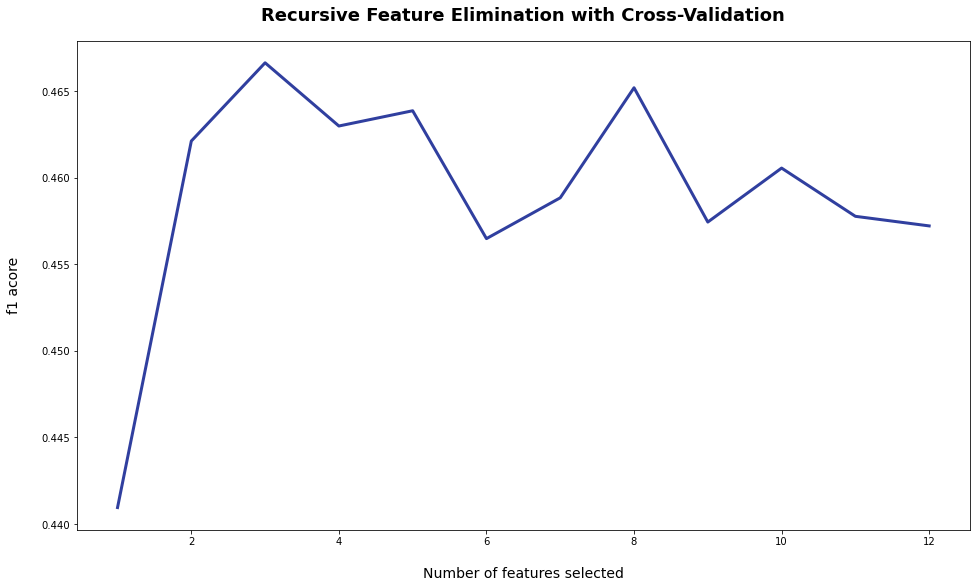

,Feature,Method
0,PAY_0_woe,RFECV
1,PAY_2_woe,RFECV
2,PAY_3_woe,RFECV
3,PAY_4_woe,RFECV
4,PAY_6_woe,RFECV


In [160]:
#5. Select features based on Recursive Feature Selection method


################################ Functions #############################################################

def rfecv_feature_selection(data, train_target,rfe_estimator,rfe_step,rfe_cv,rfe_scoring):
    
    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # rfe_estimator - base model (default: Decision Tree)
    # rfe_step -  number of features to remove at each iteration
    # rfe_cv - cross-validation splitting strategy
    # rfe_scoring - CV performance scoring metric
    

    ## Initialize RFE

    if rfe_estimator == "XGBoost":
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html       
        estimator_rfe = XGBClassifier(n_jobs = -1, random_state=101)
    elif rfe_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_rfe = RandomForestClassifier(n_jobs = -1, random_state=101)
    elif rfe_estimator == "CatBoost":
        # Manual Change in Parameters - CatBoost
        # Link to function parameters - https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
        estimator_rfe = CatBoostClassifier(iterations=50,verbose=0,random_state=101)
    elif rfe_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_rfe = lgb.LGBMClassifier(n_jobs = -1, random_state=101)
    else:
        # Manual Change in Parameters - DecisionTree
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        estimator_rfe = DecisionTreeClassifier(random_state=101)


    # Fit RFECV
    # Manual Change in Parameters - RFECV
    # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
    # Scoring metrics - https://scikit-learn.org/stable/modules/model_evaluation.html
    rfecv = RFECV(estimator = estimator_rfe, step = rfe_step, cv = rfe_cv, scoring = rfe_scoring)
    rfecv.fit(data, train_target)

    # Select feature based on RFE
    print('Optimal number of features: {}'.format(rfecv.n_features_))
    rfe_df = pd.DataFrame(columns = ['Feature', 'rfe_filter'])
    rfe_df['Feature'] = data.columns
    rfe_df['rfe_filter'] = rfecv.support_.tolist()
    rfe_df_v2 = rfe_df[rfe_df['rfe_filter']==True]
    rfe_top_features = rfe_df_v2['Feature'].tolist()
    print(rfe_top_features)
    
    rfe_top_features_df = pd.DataFrame(rfe_top_features,columns = ['Feature'])
    rfe_top_features_df['Method'] = 'RFECV'

    # Plot CV results
    %matplotlib inline
    plt.figure(figsize=(16, 9))
    plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
    plt.ylabel('f1 acore', fontsize=14, labelpad=20)
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

    plt.show()
    
    return rfe_top_features_df,rfecv

################################ Calculate RFECV #############################################################

rfe_top_features_df,rfecv = rfecv_feature_selection(train_features_v2,train_target,rfe_estimator,rfe_step,rfe_cv,rfe_scoring)
rfe_top_features_df.head(n=20)

In [161]:
#6. Select features based on Sequential Feature Selector


################################ Functions #############################################################

def sfs_feature_selection(data, train_target,sfs_feature,sfs_direction,sfs_cv,sfs_scoring):
    
    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # sfs_feature - no. of features to select
    # sfs_direction -  forward and backward selection
    # sfs_cv - cross-validation splitting strategy
    # sfs_scoring - CV performance scoring metric
    

    logistic = LogisticRegression(penalty = None)

    sfs = SequentialFeatureSelector(estimator = logistic, n_features_to_select = sfs_feature, direction = sfs_direction,cv = sfs_cv, scoring = sfs_scoring)
    sfs.fit(train_features_v2, train_target)
    sfs.get_support()

    sfs_df = pd.DataFrame(columns = ['Feature', 'SFS_filter'])
    sfs_df['Feature'] = train_features_v2.columns
    sfs_df['SFS_filter'] = sfs.get_support().tolist()

    sfs_df_v2 = sfs_df[sfs_df['SFS_filter']==True]
    sfs_top_features = sfs_df_v2['Feature'].tolist()
    print(sfs_top_features)

    log_v2 = sm.Logit(train_target, sm.add_constant(train_features_v2[sfs_top_features])).fit()
    print(log_v2.summary())
    
    sfs_top_features_df = pd.DataFrame(sfs_top_features,columns = ['Feature'])
    sfs_top_features_df['Method'] = 'Sequential_feature_selector'

    
    return sfs_top_features_df,sfs

################################ Calculate RFECV #############################################################

sfs_top_features_df,sfs = sfs_feature_selection(train_features_v2,train_target,sfs_feature,sfs_direction,sfs_cv,sfs_scoring)
sfs_top_features_df.head(n=20)

['PAY_AMT6', 'SEX_woe', 'EDUCATION_woe', 'MARRIAGE_woe', 'PAY_0_woe', 'PAY_2_woe', 'PAY_3_woe', 'PAY_4_woe', 'PAY_5_woe', 'PAY_6_woe']
Optimization terminated successfully.
         Current function value: 0.441292
         Iterations 6
                               Logit Regression Results                               
Dep. Variable:     default payment next month   No. Observations:                21000
Model:                                  Logit   Df Residuals:                    20989
Method:                                   MLE   Df Model:                           10
Date:                        Fri, 08 Jul 2022   Pseudo R-squ.:                  0.1649
Time:                                18:32:45   Log-Likelihood:                -9267.1
converged:                               True   LL-Null:                       -11097.
Covariance Type:                    nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.0

,Feature,Method
0,PAY_AMT6,Sequential_feature_selector
1,SEX_woe,Sequential_feature_selector
2,EDUCATION_woe,Sequential_feature_selector
3,MARRIAGE_woe,Sequential_feature_selector
4,PAY_0_woe,Sequential_feature_selector
5,PAY_2_woe,Sequential_feature_selector
6,PAY_3_woe,Sequential_feature_selector
7,PAY_4_woe,Sequential_feature_selector
8,PAY_5_woe,Sequential_feature_selector
9,PAY_6_woe,Sequential_feature_selector


In [162]:
#7. Select features based on BorutaPy method



################################ Functions #############################################################

def borutapy_feature_selection(data, train_target,borutapy_estimator,borutapy_trials,borutapy_green_blue):
    
    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # borutapy_estimator - base model (default: XG Boost)
    # borutapy_trials -  number of iteration
    # borutapy_green_blue - choice for green and blue features
    

    ## Initialize borutapy
     
    if borutapy_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_borutapy = RandomForestClassifier(n_jobs = -1, random_state=101,max_depth=7)
    elif borutapy_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_borutapy = lgb.LGBMClassifier(n_jobs = -1, random_state=101,max_depth=7)
    else:
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html       
        estimator_borutapy = XGBClassifier(n_jobs = -1, random_state=101,max_depth=7)

    ## fit Borutapy
    # Manual Change in Parameters - Borutapy
    # Link to function parameters - https://github.com/scikit-learn-contrib/boruta_py
    borutapy = BorutaPy(estimator = estimator_borutapy, n_estimators = 'auto', max_iter = borutapy_trials)
    borutapy.fit(np.array(data), np.array(train_target))
    
    ## print results
    green_area = data.columns[borutapy.support_].to_list()
    blue_area = data.columns[borutapy.support_weak_].to_list()
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)


    if borutapy_green_blue == "both":
        borutapy_top_features = green_area + blue_area
    else:
        borutapy_top_features = green_area
        
    borutapy_top_features_df = pd.DataFrame(borutapy_top_features,columns = ['Feature'])
    borutapy_top_features_df['Method'] = 'Borutapy'
    
    return borutapy_top_features_df,borutapy

################################ Calculate borutapy #############################################################

borutapy_top_features_df,boruta = borutapy_feature_selection(train_features_v2, train_target,borutapy_estimator,borutapy_trials,borutapy_green_blue)

borutapy_top_features_df.head(n=20)

features in the green area: ['LIMIT_BAL', 'BILL_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_0_woe', 'PAY_2_woe', 'PAY_3_woe', 'PAY_4_woe', 'PAY_5_woe', 'PAY_6_woe']
features in the blue area: ['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT6', 'EDUCATION_woe']


,Feature,Method
0,LIMIT_BAL,Borutapy
1,BILL_AMT1,Borutapy
2,PAY_AMT2,Borutapy
3,PAY_AMT3,Borutapy
4,PAY_0_woe,Borutapy
5,PAY_2_woe,Borutapy
6,PAY_3_woe,Borutapy
7,PAY_4_woe,Borutapy
8,PAY_5_woe,Borutapy
9,PAY_6_woe,Borutapy


  0%|          | 0/10 [00:00<?, ?it/s]

6 attributes confirmed important: ['LIMIT_BAL', 'PAY_0_woe', 'PAY_AMT1', 'BILL_AMT1', 'PAY_2_woe', 'PAY_AMT2']
13 attributes confirmed unimportant: ['PAY_AMT4', 'PAY_4_woe', 'BILL_AMT4', 'SEX_woe', 'BILL_AMT5', 'MARRIAGE_woe', 'EDUCATION_woe', 'BILL_AMT2', 'PAY_5_woe', 'PAY_6_woe', 'PAY_3_woe', 'PAY_AMT6', 'AGE']
4 tentative attributes remains: ['BILL_AMT6', 'PAY_AMT3', 'PAY_AMT5', 'BILL_AMT3']


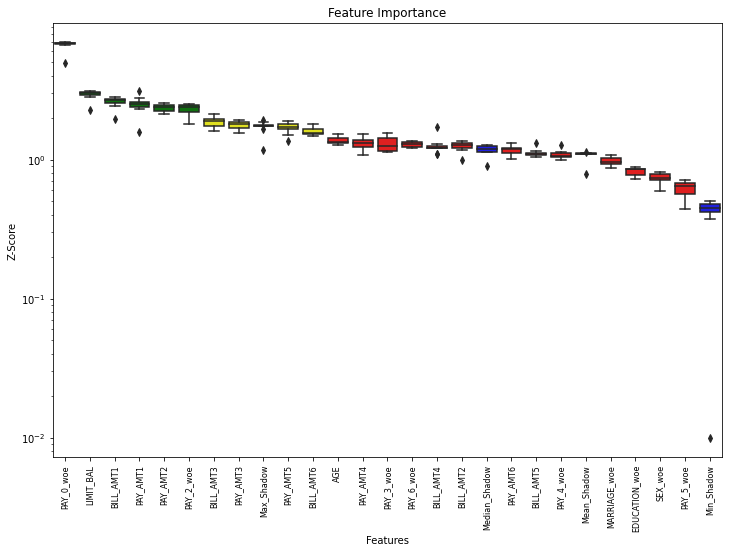

features in the green area: ['LIMIT_BAL', 'PAY_0_woe', 'PAY_AMT1', 'BILL_AMT1', 'PAY_2_woe', 'PAY_AMT2']
features in the blue area: ['BILL_AMT6', 'PAY_AMT3', 'PAY_AMT5', 'BILL_AMT3']


,Feature,Method
0,LIMIT_BAL,Borutashap
1,PAY_0_woe,Borutashap
2,PAY_AMT1,Borutashap
3,BILL_AMT1,Borutashap
4,PAY_2_woe,Borutashap
5,PAY_AMT2,Borutashap
6,BILL_AMT6,Borutashap
7,PAY_AMT3,Borutashap
8,PAY_AMT5,Borutashap
9,BILL_AMT3,Borutashap


In [163]:
#8. Select features based on BorutaShap method


################################ Functions #############################################################

def borutashap_feature_selection(data, train_target,borutashap_estimator,borutashap_trials,borutashap_green_blue):
    
    #Inputs
    # data - Input feature data 
    # train_target - Target variable training data
    # borutashap_estimator - base model (default: XG Boost)
    # borutashap_trials -  number of iteration
    # borutashap_green_blue - choice for green and blue features
    

    ## Initialize borutashap
     
    if borutashap_estimator == "RandomForest":
        # Manual Change in Parameters - RandomForest
        # Link to function parameters - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
        estimator_borutashap = RandomForestClassifier(n_jobs = -1, random_state=101,max_depth=7)
    elif borutashap_estimator == "LightGBM":
        # Manual Change in Parameters - LightGBM
        # Link to function parameters - https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
        estimator_borutashap = lgb.LGBMClassifier(n_jobs = -1, random_state=101,max_depth=7)
    else:
        # Manual Change in Parameters - XGBoost
        # Link to function parameters - https://xgboost.readthedocs.io/en/stable/parameter.html       
        estimator_borutashap = XGBClassifier(n_jobs = -1, random_state=101,max_depth=7)

    ## fit BorutaShap
    # Manual Change in Parameters - BorutaShap
    # Link to function parameters - https://github.com/scikit-learn-contrib/boruta_py
    borutashap = BorutaShap(model = estimator_borutashap, importance_measure = 'shap', classification = True)
    borutashap.fit(X = data, y = train_target, n_trials = borutashap_trials)
    
    ## print results
    %matplotlib inline
    borutashap.plot(which_features = 'all')

    ## print results
    green_area = borutashap.accepted
    blue_area = borutashap.tentative
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)


    if borutashap_green_blue == "both":
        borutashap_top_features = green_area + blue_area
    else:
        borutashap_top_features = green_area
        
    borutashap_top_features_df = pd.DataFrame(borutashap_top_features,columns = ['Feature'])
    borutashap_top_features_df['Method'] = 'Borutashap'

    
    return borutashap_top_features_df,borutashap

################################ Calculate borutashap #############################################################

borutashap_top_features_df,borutashap = borutashap_feature_selection(train_features_v2, train_target,borutashap_estimator,borutashap_trials,borutashap_green_blue)
borutashap_top_features_df.head(n=20)

Selecting features which are picked by more than  4  methods
Final Features Selected:  ['LIMIT_BAL', 'PAY_0_woe', 'PAY_2_woe', 'PAY_3_woe', 'PAY_4_woe', 'PAY_5_woe', 'PAY_6_woe', 'PAY_AMT1']


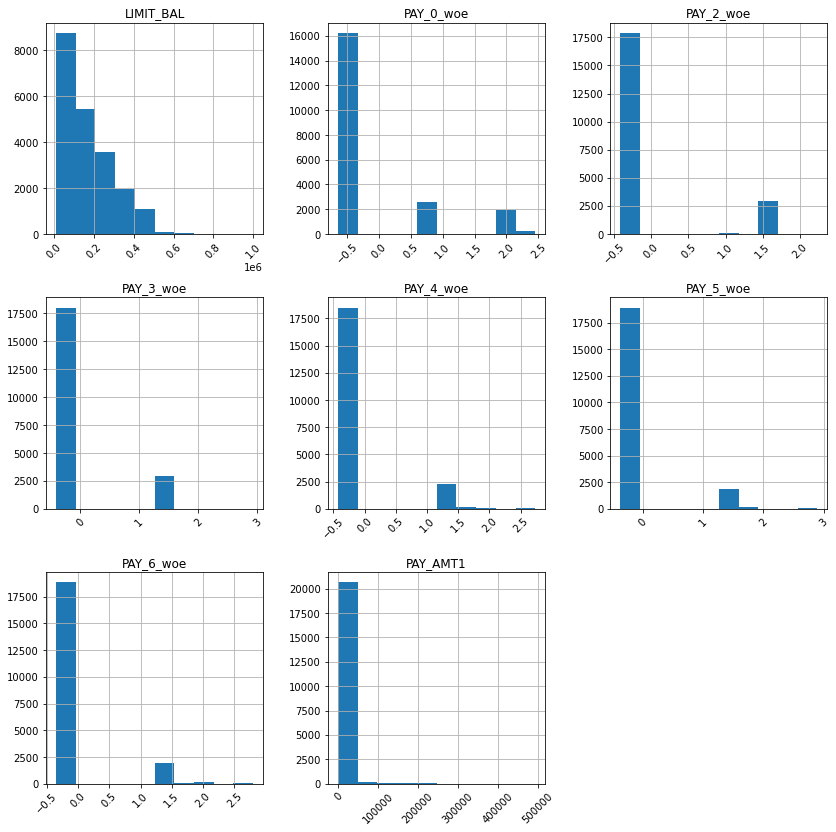

,Features,Count_Method
8,LIMIT_BAL,5
10,PAY_0_woe,8
11,PAY_2_woe,7
12,PAY_3_woe,6
13,PAY_4_woe,6
14,PAY_5_woe,5
15,PAY_6_woe,6
16,PAY_AMT1,5


In [165]:
# Methods Selected

selected_method = [corr_top_features_df, woe_top_features_df,beta_top_features_df,lasso_top_features_df,
                   rfe_top_features_df,sfs_top_features_df,borutapy_top_features_df,borutashap_top_features_df]


# Combining features from all the models
master_df_feature_selection = pd.concat(selected_method, axis =0)
number_of_methods = len(selected_method)
selection_threshold = int(len(selected_method)/2)
print('Selecting features which are picked by more than ', selection_threshold, ' methods')
master_df_feature_selection_v2 = pd.DataFrame(master_df_feature_selection.groupby('Feature').size()).reset_index()
master_df_feature_selection_v2.columns = ['Features', 'Count_Method']
master_df_feature_selection_v3 = master_df_feature_selection_v2[master_df_feature_selection_v2['Count_Method']>selection_threshold]
final_features = master_df_feature_selection_v3['Features'].tolist()
print('Final Features Selected: ',final_features)
train_features_v2[final_features].hist(figsize = (14,14), xrot =  45)
plt.show()
master_df_feature_selection_v3.head(n=30)

In [27]:
# Fit XG Boost and Test Performance

def deafult_xgboost(train_features, test_features, train_target, test_target, features, Target,xgb_model_objective, xgb_model_test_metric):
    model = XGBClassifier(random_state = 101, objective = xgb_model_objective)
    model.fit(train_features, train_target, eval_set = [(train_features, train_target),(test_features,test_target)], eval_metric = xgb_model_test_metric,verbose = False)
    
    pred_train_prob, pred_test_prob, pred_all_prob, pred_train,pred_test = performance_metrics(model,train_features, test_features,features, Target, train_target, test_target)
    return model, pred_train_prob, pred_test_prob, pred_all_prob, pred_train,pred_test 

xgb_model, xgb_pred_train_prob, xgb_pred_test_prob, xgb_pred_all_prob, xgb_pred_train,xgb_pred_test = deafult_xgboost(train_features, test_features, train_target, test_target, features, Target,xgb_model_objective, xgb_model_test_metric)

gini_train:  0.5504827464106237
gini_test:  0.31188643946983863
gini_all:  0.4788981549333404
ks_train:  0.5504827464106236
ks_test:  0.3118864394698386
ks_all:  0.47889815493334054
Training_Confusion_Matrix: 
[[16024   331]
 [ 1994  2651]]
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93     16355
         1.0       0.89      0.57      0.70      4645

    accuracy                           0.89     21000
   macro avg       0.89      0.78      0.81     21000
weighted avg       0.89      0.89      0.88     21000

Test_Confusion_Matrix: 
[[6597  412]
 [1253  738]]
              precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      7009
         1.0       0.64      0.37      0.47      1991

    accuracy                           0.81      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.81      0.80      9000



In [30]:
# Fit LGB Boost and Test Performance

def deafult_lgb_boost(train_features, test_features, train_target, test_target, features, Target,lgb_model_objective, lgb_model_test_metric):
    train_features = train_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
    test_features = test_features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
    model = lgb.LGBMClassifier(random_state = 101, objective = lgb_model_objective)
    model.fit(train_features, train_target, eval_set = [(train_features, train_target),(test_features,test_target)],eval_metric = lgb_model_test_metric, verbose = False)
    
    pred_train_prob, pred_test_prob, pred_all_prob, pred_train,pred_test = performance_metrics(model,train_features, test_features,features, Target, train_target, test_target)
    return model, pred_train_prob, pred_test_prob, pred_all_prob, pred_train,pred_test 

lgb_model, lgb_pred_train_prob, lgb_pred_test_prob, lgb_pred_all_prob, lgb_pred_train,lgb_pred_test = deafult_lgb_boost(train_features, test_features, train_target, test_target, features, Target,lgb_model_objective, lgb_model_test_metric)

gini_train:  0.40387803047230797
gini_test:  0.32519572489098647
gini_all:  0.3802715913850865
ks_train:  0.40387803047230797
ks_test:  0.32519572489098647
ks_all:  0.38027159138508637
Training_Confusion_Matrix: 
[[15760   595]
 [ 2600  2045]]
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     16355
         1.0       0.77      0.44      0.56      4645

    accuracy                           0.85     21000
   macro avg       0.82      0.70      0.73     21000
weighted avg       0.84      0.85      0.83     21000

Test_Confusion_Matrix: 
[[6641  368]
 [1239  752]]
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      7009
         1.0       0.67      0.38      0.48      1991

    accuracy                           0.82      9000
   macro avg       0.76      0.66      0.69      9000
weighted avg       0.80      0.82      0.80      9000



In [31]:
# Fit cat Boost and Test Performance

def deafult_cat_boost(train_features, test_features, train_target, test_target, features, Target,cat_model_objective, cat_model_test_metric):
    model = CatBoostClassifier(random_state = 101, objective = cat_model_objective, eval_metric = cat_model_test_metric)
    model.fit(train_features, train_target, eval_set = [(train_features, train_target),(test_features,test_target)], verbose = False)
    
    pred_train_prob, pred_test_prob, pred_all_prob, pred_train,pred_test = performance_metrics(model,train_features, test_features,features, Target, train_target, test_target)
    return model, pred_train_prob, pred_test_prob, pred_all_prob, pred_train,pred_test 

cat_model, cat_pred_train_prob, cat_pred_test_prob, cat_pred_all_prob, cat_pred_train,cat_pred_test = deafult_cat_boost(train_features, test_features, train_target, test_target, features, Target,cat_model_objective, cat_model_test_metric)

gini_train:  0.36137021724987073
gini_test:  0.3165146282826865
gini_all:  0.3479126477946475
ks_train:  0.36137021724987073
ks_test:  0.31651462828268656
ks_all:  0.34791264779464737
Training_Confusion_Matrix: 
[[15688   667]
 [ 2777  1868]]
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90     16355
         1.0       0.74      0.40      0.52      4645

    accuracy                           0.84     21000
   macro avg       0.79      0.68      0.71     21000
weighted avg       0.82      0.84      0.82     21000

Test_Confusion_Matrix: 
[[6640  369]
 [1256  735]]
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      7009
         1.0       0.67      0.37      0.47      1991

    accuracy                           0.82      9000
   macro avg       0.75      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000



# Unsupervised Approach

In [11]:
# Isolation Forest
iso_forest = IsolationForest(n_estimators = 100, 
                        max_samples = 256,
                        contamination = anomalies_ratio, 
                        random_state = np.random.RandomState(42))
iso_forest.fit(train_features)
pred_train_v2 = iso_forest.predict(train_features)
pred_train_v2 = [1 if x == -1 else 0 for x in pred_train_v2]



import matplotlib.pyplot as plt
print('Training_Confusion_Matrix: ')
print(confusion_matrix(train_target,pred_train_v2))
print(classification_report(train_target,pred_train_v2))
sns.heatmap(confusion_matrix(train_target,pred_train_v2), annot = True, fmt = '.1f')
plt.show()


Training_Confusion_Matrix: 
[[12615  3740]
 [ 2505  2140]]
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80     16355
         1.0       0.36      0.46      0.41      4645

    accuracy                           0.70     21000
   macro avg       0.60      0.62      0.60     21000
weighted avg       0.73      0.70      0.71     21000



In [68]:
# Extended Isolation Forest
ext_iso_forest = iso.iForest(train_features.values, 
                     ntrees = 100, 
                     sample_size = 256, 
                     ExtensionLevel = len(train_features.columns) - 1)

# calculate anomaly scores
anomaly_scores = ext_iso_forest.compute_paths(X_in = train_features.values)
# sort the scores
anomaly_scores_sorted = np.argsort(anomaly_scores)
# retrieve indices of anomalous observations
indices_with_preds = anomaly_scores_sorted[-int(np.ceil(anomalies_ratio * train_features.shape[0])):]
# create predictions 
pred_train_v2 = np.zeros_like(train_target)
pred_train_v2[indices_with_preds] = 1

import matplotlib.pyplot as plt
print('Training_Confusion_Matrix: ')
print(confusion_matrix(train_target,pred_train_v2))
print(classification_report(train_target,pred_train_v2))
sns.heatmap(confusion_matrix(train_target,pred_train_v2), annot = True, fmt = '.1f')
plt.show()

Training_Confusion_Matrix: 
[[11381  4974]
 [ 3738   907]]
              precision    recall  f1-score   support

         0.0       0.75      0.70      0.72     16355
         1.0       0.15      0.20      0.17      4645

    accuracy                           0.59     21000
   macro avg       0.45      0.45      0.45     21000
weighted avg       0.62      0.59      0.60     21000



In [11]:
# Minimum Covariance Determinant

# instantiate model
Min_Cov_Determinant = EllipticEnvelope(contamination = anomalies_ratio, random_state = np.random.RandomState(42)) 
# fit model

Min_Cov_Determinant.fit(train_features)

# predict on new data 
pred_train_v2 = Min_Cov_Determinant.predict(train_features)

pred_train_v2

array([1, 1, 1, ..., 1, 1, 1])

In [15]:
from sklearn.svm import OneClassSVM
# define outlier detection model
model = OneClassSVM(gamma='scale', nu=0.01)
# fit on majority class

model.fit(train_features)
# detect outliers in the test set
pred_train_v2 = model.predict(train_features)
# mark inliers 1, outliers -1
pred_train_v2 = [1 if x == -1 else 0 for x in pred_train_v2]
# calculate score
import matplotlib.pyplot as plt
print('Training_Confusion_Matrix: ')
print(confusion_matrix(train_target,pred_train_v2))
print(classification_report(train_target,pred_train_v2))
sns.heatmap(confusion_matrix(train_target,pred_train_v2), annot = True, fmt = '.1f')
plt.show()


Training_Confusion_Matrix: 
[[16177   178]
 [ 4611    34]]
              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87     16355
         1.0       0.16      0.01      0.01      4645

    accuracy                           0.77     21000
   macro avg       0.47      0.50      0.44     21000
weighted avg       0.64      0.77      0.68     21000



In [10]:
from sklearn.neighbors import LocalOutlierFactor
 
# make a prediction with a lof model
def lof_predict(model, trainX, testX):
	# create one large dataset
	composite = vstack((trainX, testX))
	# make prediction on composite dataset
	yhat = model.fit_predict(composite)
	# return just the predictions on the test set
	return yhat[len(trainX):]


# define outlier detection model
model = LocalOutlierFactor(contamination=0.01)

# detect outliers in the test set
pred_train_v2 = lof_predict(model, trainX, testX)

NameError: name 'trainX' is not defined